In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from zipfile import ZipFile
from io import BytesIO
import pandas as pd

# Image manipulation.
import PIL.Image
from IPython.display import display

#loading and checking the format of the ground truth csv
train_truth = pd.read_csv('train.truth.csv')
train_truth.head()

,fn,label
0,0-10049200_1891-09-16_1958.jpg,rotated_left
1,0-10110600_1985-09-17_2012.jpg,rotated_left
2,0-10126400_1964-07-07_2010.jpg,upright
3,0-1013900_1917-10-15_1960.jpg,rotated_right
4,0-10166400_1960-03-12_2008.jpg,upside_down


In [2]:
train_truth.label.value_counts()

rotated_right    12314
rotated_left     12266
upright          12212
upside_down      12104
Name: label, dtype: int64

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator

# create a data generation with the train truth images and dataframe
datagen = ImageDataGenerator(validation_split=0.2)


train_generator=datagen.flow_from_dataframe(dataframe=train_truth,directory="train/",x_col="fn",y_col="label",
                                            subset="training",batch_size=32,seed=42,shuffle=True,
                                            class_mode="categorical",target_size=(32,32))

validation_generator=datagen.flow_from_dataframe(dataframe=train_truth,directory="train/",x_col="fn",y_col="label",
                                            subset="validation",batch_size=32,seed=42,shuffle=True,
                                            class_mode="categorical",target_size=(32,32))

Found 39117 validated image filenames belonging to 4 classes.
Found 9779 validated image filenames belonging to 4 classes.


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

#using the CIFAR-10 example
batch_size = 32
steps_per_epoch= 39117/batch_size
num_classes = 4
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_image_rotation_trained_model.h5'

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

model.fit_generator(train_generator,steps_per_epoch=steps_per_epoch,epochs=epochs,validation_data=validation_generator,validation_steps=800)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1223/1222 [==============================] - 1118s 915ms/step - loss: 1.4268 - accuracy: 0.6527 - val_loss: 0.4267 - val_accuracy: 0.8487
Epoch 2/20
1223/1222 [==============================] - 218s 178ms/step - loss: 0.4665 - accuracy: 0.8241 - val_loss: 0.2926 - val_accuracy: 0.8931
Epoch 3/20
1223/1222 [==============================] - 216s 176ms/step - loss: 0.3618 - accuracy: 0.8673 - val_loss: 0.2351 - val_accuracy: 0.9152
Epoch 4/20
1223/1222 [==============================] - 213s 174ms/step - loss: 0.2900 - accuracy: 0.8968 - val_loss: 0.1992 - val_accuracy: 0.9324
Epoch 5/20
1223/1222 [==============================] - 214s 175ms/step - loss: 0.2461 - accuracy: 0.9150 - val_loss: 0.1608 - val_accuracy: 0.9442
Epoch 6/20
1223/1222 [==============================] - 214s 175ms/step - loss: 0.2193 - accuracy: 0.9242 - val_loss: 0.1668 - val_accuracy: 0.9432
Epoch 7/20
1223/1222 [=============

Epoch 17/20
1223/1222 [==============================] - 210s 171ms/step - loss: 0.1326 - accuracy: 0.9577 - val_loss: 0.1002 - val_accuracy: 0.9680
Epoch 18/20
1223/1222 [==============================] - 215s 176ms/step - loss: 0.1282 - accuracy: 0.9604 - val_loss: 0.1063 - val_accuracy: 0.9677
Epoch 19/20
1223/1222 [==============================] - 215s 176ms/step - loss: 0.1283 - accuracy: 0.9600 - val_loss: 0.0960 - val_accuracy: 0.9689
Epoch 20/20
1223/1222 [==============================] - 219s 179ms/step - loss: 0.1260 - accuracy: 0.9603 - val_loss: 0.1338 - val_accuracy: 0.9594


In [6]:
# Save model
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)



Saved trained model at c:\DeeperSystems\saved_models\keras_image_rotation_trained_model.h5 


In [9]:
# Score trained model.
scores = model.evaluate_generator(generator=validation_generator,steps=steps_per_epoch)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.13378317654132843
Test accuracy: 0.9594027996063232


In [15]:
#predicting the values on the test set
test_datagen = ImageDataGenerator()
test_generator=test_datagen.flow_from_directory(directory="test/",classes=['test'],batch_size=32,seed=42,
                                                class_mode="categorical",target_size=(32,32))

predict = model.predict(test_generator,steps = steps_per_epoch)

Found 5361 images belonging to 1 classes.


In [17]:
#saving the predicted labels
predicted_class_indices=np.argmax(predict,axis=1)
predicted_class_indices

array([0, 3, 1, ..., 2, 1, 0], dtype=int64)

In [18]:
#converting the predicited labels to its respective categorical values
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

['rotated_left',
 'upside_down',
 'rotated_right',
 'rotated_left',
 'rotated_right',
 'rotated_right',
 'rotated_right',
 'upside_down',
 'rotated_right',
 'upside_down',
 'upright',
 'rotated_left',
 'upside_down',
 'upright',
 'upright',
 'rotated_right',
 'upside_down',
 'rotated_left',
 'rotated_left',
 'upright',
 'rotated_left',
 'rotated_left',
 'rotated_left',
 'upside_down',
 'rotated_left',
 'upside_down',
 'upright',
 'upright',
 'upside_down',
 'rotated_right',
 'rotated_left',
 'rotated_left',
 'rotated_right',
 'upside_down',
 'upside_down',
 'rotated_left',
 'upside_down',
 'rotated_left',
 'upright',
 'upside_down',
 'upright',
 'rotated_left',
 'rotated_left',
 'rotated_right',
 'upright',
 'upside_down',
 'upside_down',
 'rotated_left',
 'rotated_left',
 'rotated_left',
 'rotated_right',
 'upside_down',
 'rotated_left',
 'upside_down',
 'upright',
 'rotated_right',
 'rotated_left',
 'rotated_left',
 'upright',
 'upside_down',
 'upright',
 'rotated_left',
 'upright',


In [19]:
#saving the predicted images to a csv with the filename and the predicted labels
filenames=test_generator.filenames

results=pd.DataFrame({"fn":filenames,"label":predictions})

results.to_csv("test.preds.csv",index=False)

In [24]:
#due to our subdirectories the filename was saved with an unwanted subfolder so I'm going to remove it
test_preds = pd.read_csv('test.preds.csv')
test_preds.loc[:,'fn'] = test_preds.loc[:,'fn'].astype(str).str.strip('\test\ ')
test_preds.head()

,fn,label
0,90-10184590_1979-06-16_2006.jpg,rotated_left
1,90-1019890_1931-08-10_1978.jpg,upside_down
2,90-10241990_1984-11-28_2007.jpg,rotated_right
3,90-102690_1966-09-09_2011.jpg,rotated_left
4,90-10303590_1983-01-26_2010.jpg,rotated_right


In [25]:
test_preds.to_csv("test.preds.csv",index=False)

Checking the labels number

In [30]:
predictions[0],predicted_class_indices[0]

('rotated_left', 0)

In [31]:
predictions[1],predicted_class_indices[1]

('upside_down', 3)

In [32]:
predictions[2],predicted_class_indices[2]

('rotated_right', 1)

In [33]:
predictions[10], predicted_class_indices[10]

('upright', 2)

In [34]:
len(predictions), len(predicted_class_indices)

(5361, 5361)

Creating an array of the angles to rotate the images according tho the predictions

In [56]:
angles = []
for i in range (0,len(predicted_class_indices)):
    if predicted_class_indices[i] == 0:
        angles.append(-90)
    elif predicted_class_indices[i] == 1:
        angles.append(90)
    elif predicted_class_indices[i] == 2:
        angles.append(0)
    elif predicted_class_indices[i] == 3:
        angles.append(180)

angles

[-90,
 180,
 90,
 -90,
 90,
 90,
 90,
 180,
 90,
 180,
 0,
 -90,
 180,
 0,
 0,
 90,
 180,
 -90,
 -90,
 0,
 -90,
 -90,
 -90,
 180,
 -90,
 180,
 0,
 0,
 180,
 90,
 -90,
 -90,
 90,
 180,
 180,
 -90,
 180,
 -90,
 0,
 180,
 0,
 -90,
 -90,
 90,
 0,
 180,
 180,
 -90,
 -90,
 -90,
 90,
 180,
 -90,
 180,
 0,
 90,
 -90,
 -90,
 0,
 180,
 0,
 -90,
 0,
 180,
 180,
 180,
 0,
 90,
 0,
 -90,
 180,
 -90,
 -90,
 90,
 0,
 0,
 0,
 180,
 180,
 0,
 90,
 0,
 -90,
 180,
 -90,
 90,
 -90,
 0,
 0,
 180,
 90,
 0,
 90,
 0,
 90,
 180,
 90,
 90,
 90,
 180,
 180,
 90,
 0,
 -90,
 90,
 0,
 180,
 -90,
 180,
 0,
 -90,
 180,
 90,
 -90,
 0,
 90,
 180,
 90,
 -90,
 90,
 -90,
 -90,
 0,
 -90,
 -90,
 0,
 -90,
 180,
 0,
 0,
 180,
 180,
 90,
 90,
 90,
 90,
 90,
 180,
 -90,
 -90,
 180,
 0,
 0,
 90,
 0,
 -90,
 180,
 90,
 90,
 180,
 0,
 0,
 90,
 90,
 0,
 180,
 0,
 90,
 90,
 0,
 -90,
 0,
 -90,
 0,
 180,
 -90,
 -90,
 -90,
 90,
 -90,
 180,
 90,
 90,
 90,
 -90,
 90,
 90,
 -90,
 180,
 180,
 -90,
 0,
 0,
 180,
 180,
 0,
 90,
 90,
 0,
 180,

In [57]:
test_preds['fn'][0], angles[0]

('90-10184590_1979-06-16_2006.jpg', -90)

In [88]:
#Checking some of the images and the outcome of the predictions

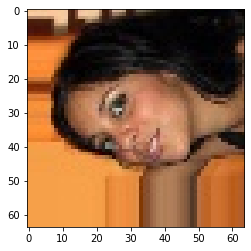

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from zipfile import ZipFile
from io import BytesIO

# Image manipulation.
import PIL.Image
from IPython.display import display


filename = test_preds['fn'][0]

image = PIL.Image.open('test/test/'+filename)



plt.imshow(image)

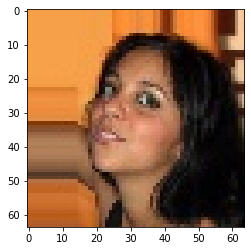

In [59]:
rotated = image.rotate(angles[0])
plt.imshow(rotated)

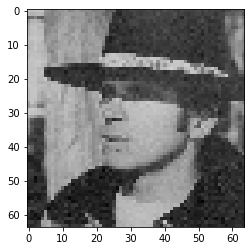

In [60]:
filename2 = test_preds['fn'][1]

image2 = PIL.Image.open('test/test/'+filename2)



plt.imshow(image2)

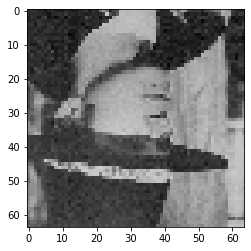

In [65]:
rotated2 = image2.rotate(angles[1])
plt.imshow(rotated2)

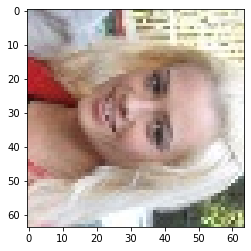

In [61]:
filename3 = test_preds['fn'][2]

image3 = PIL.Image.open('test/test/'+filename3)



plt.imshow(image3)

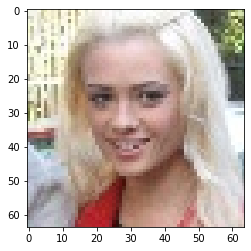

In [64]:
rotated3 = image3.rotate(angles[2])
plt.imshow(rotated2)

In [66]:
path = 'pred_images/'+test_preds['fn'][2]
rotated3.save(path+'.jpg', 'JPEG')

In [67]:
rotated3_array = np.array(rotated3)
rotated3_array.shape

(64, 64, 3)

Creating new images in PNG format with the predicted rotation in an existing directory

In [79]:
rotated_images = []

for i in range (0,test_preds.shape[0]):
    filename = test_preds['fn'][i]
    image = PIL.Image.open('test/test/'+filename)
    rotated = image.rotate(angles[i])
    path = 'pred_images/'+test_preds['fn'][i].strip('\.jpg')+'.png'
    rotated.save(path, 'PNG')
    rotated_array = np.array(rotated)
    rotated_images.append(np.array(rotated_array, np.uint8))

In [82]:
len(rotated_images)

5361

Converting the list of images to a numpy array and saving it to a file

In [85]:
images_array = np.array(rotated_images)
images_array.shape

(5361, 64, 64, 3)

In [87]:
# saving the array to a file
np.save('rotated_images.', images_array)